In [1]:
%matplotlib inline
%load_ext memory_profiler 
# pip install memory_profiler

ModuleNotFoundError: No module named 'memory_profiler'

In [2]:
from KnackpackData import n_items,weights,values,max_weight,getDiff
from Timer import *
import matplotlib.pyplot as plt
import numpy as np
import random
t = Timer()

## Simulated Annealing

Simulated Annealing (SA) jest stochastycznym algorytmem do znajowania globalnych ekstremówó w dużyc problemach optymalizacyjnych. Wykorzystuje się go bardzo często w problemach optymalizacji wartości dyskretnych.

SA przy każdej iteracji generuje nowy stan, bazujący na obecnym, w którym zmienia losowo jeden bit. Następnie porównywane są wartości nowego i obecnego stanu. Jeżeli wartości nwoego stanu są lepsze od poprzedniego i są akceptowalne (nie przekraczają limitu wagi) są akceptowane. Jeżeli nowo wygenerowany stan jest błędny, poniewaz przykładowo przekracza maksymalną wagę to wciąż może zostać wykorzystany w następnej iteracji w pewnym prawdopodobieństwem. Takie podejście pozwala algorytmowi uciekać z minimów lokalnych.

Do poprawnej pracy algorytmu definiuje się stan początkowy jako pusty plecak oraz parametry wyżarzania, na podsawie których osiągany jest warunek stopu.

In [13]:
class SimulatedAnnealing:
    def __init__(self, initial_temp = 1000, alpha = 0.999, frozen_level = 0.1, n_items = 16, values = [], weights = [], max_weight = 3):
        self.initial_temp = initial_temp
        self.alpha = alpha
        self.frozen_level = frozen_level
        self.n_items = n_items
        self.values = values
        self.weights = weights
        self.max_weight = max_weight
        self.min_weight = max_weight - 1
        
    def setInitialValues(self):
        '''Wyzeruj tablice wyników oraz ustaw wartości początkowe.'''
        
        # Stan początkowy jest po prostu pustym plecakiem.
        self.initial_state = np.zeros(self.n_items).astype(bool)
        self.best_state = self.initial_state
        self.current_state = self.initial_state
        
        self.temperature = self.initial_temp

        # Tablice wyników zawierają tylko zerowy stan.
        self.scores_table = [np.sum(self.values[self.initial_state])]
        self.best_scores_table = [np.sum(self.values[self.initial_state])]
        self.best_value_index = 0
    
    def run(self):
        if self.temperature is None:
            self.setInitialValues()
            
        it = 0
        
        while self.temperature > self.frozen_level:
            it += 1
            # Generate next state
            next_state = np.copy(self.current_state)
            next_state ^= np.array([np.random.uniform() < self.temperature/self.initial_temp for _ in range(self.n_items)])
            next_state = self.drop_or_add_items(next_state)
    
            self.scores_table.append(np.sum(self.values[next_state]))

            if np.sum(self.values[next_state]) > np.sum(self.values[self.current_state]):
                # If next state is better than current - set this state as current
                self.current_state = np.copy(next_state)

                # If new state is better than the best - set this state as best
                if self.fitness():
                    self.best_state = np.copy(self.current_state)
                    self.best_value_index = it
                    self.best_scores_table.append(np.sum(self.values[self.best_state]))
            else:
                # If the new solution is not better, accept it with a probability of e^(-delta/temp)
                acceptance_function = np.exp(-(1.0/np.sum(self.values[next_state]) - 1.0/np.sum(self.values[self.current_state])) / self.temperature)
                if acceptance_function > random.uniform(0, 1):
                    self.current_state = np.copy(next_state)
            self.temperature = self.initial_temp*pow(self.alpha,it)
        
    def fitness(self):
        return np.sum(self.values[self.current_state]) > np.sum(self.values[self.best_state])
        
    def drop_or_add_items(self, next_state):
        while np.sum(self.weights[next_state]) < self.min_weight:
            idx = random.choice(np.where(next_state==False)[0])
            next_state[idx] = True
        
        while np.sum(self.weights[next_state]) > self.max_weight:
            idx = random.choice(np.where(next_state==True)[0])
            next_state[idx] = False
            
        return next_state
        
        
    def results(self):
        best_value = np.sum(self.values[self.best_state])
        best_weight = np.sum(self.weights[self.best_state])
#         print("Best value: ",best_value)
#         print("Best weight: ",best_weight)
#         print("Difference (value, weight):", getDiff(n_items,best_value, best_weight))
        return best_value
        
    def plot_results(self, plot = 'best_of_all'):
        if plot == 'best_of_all':
            plt.figure(figsize=(16, 12), dpi=80)
            plt.scatter(self.best_value_index, np.array(self.scores_table)[self.best_value_index], color="r", s=200, zorder=2)
            plt.plot(np.arange(np.array(self.scores_table).size), np.array(self.scores_table), color="b", zorder=1)
            plt.title('Value changes')
        elif plot == 'best_changes':
            plt.figure(figsize=(16, 12), dpi=80)
            plt.plot(np.arange(np.array(self.best_scores_table).size), np.array(self.best_scores_table), color="b")
            plt.title('Best results changes')
            
        plt.ylabel('Value')
        plt.xlabel('Iteration')
        plt.show()

In [14]:
from pandas import read_csv
max_weight = 3
data_nc16 = read_csv("Data//no_correlation_16")
n_items = data_nc16.shape[0]
values = data_nc16.value.values
weights = data_nc16.weight.values
# np.sqrt(np.sum(data_nc16.weight.values))

In [15]:
np.random.seed(seed=42)
random.seed(a=42)
data = np.array([(temperature, cooling/100) for temperature in range(100, 2700, 200) for cooling in range(90, 102, 3)])
tests = len(data)
results = np.zeros(tests)
for i, dat in enumerate(data):    
    SA = SimulatedAnnealing(dat[0], dat[1], 0.0001, 16, values, weights, max_weight)
    SA.setInitialValues()
    # t.start()
    SA.run()
    # t.stop()
    results[i] = SA.results()
    print(f"Tests finished: {i}/{tests-1}", end="\r")

In [16]:
from pandas import DataFrame
df = DataFrame(data=np.transpose([data[:,0], data[:,1], results]), columns=["temp", "cooling", "value"])
df.sort_values(by=['value'], ascending=False, inplace=True)
best_temp = df.values[0][0]
best_cooling = df.values[0][1]
df.head()

,temp,cooling,value
51,2500.0,0.99,4.225162
14,700.0,0.96,4.126425
11,500.0,0.99,4.126425
9,500.0,0.93,4.091106
35,1700.0,0.99,4.091106


In [17]:
# best_temp = df.values[0]

## Visualisations

### Best value in all data

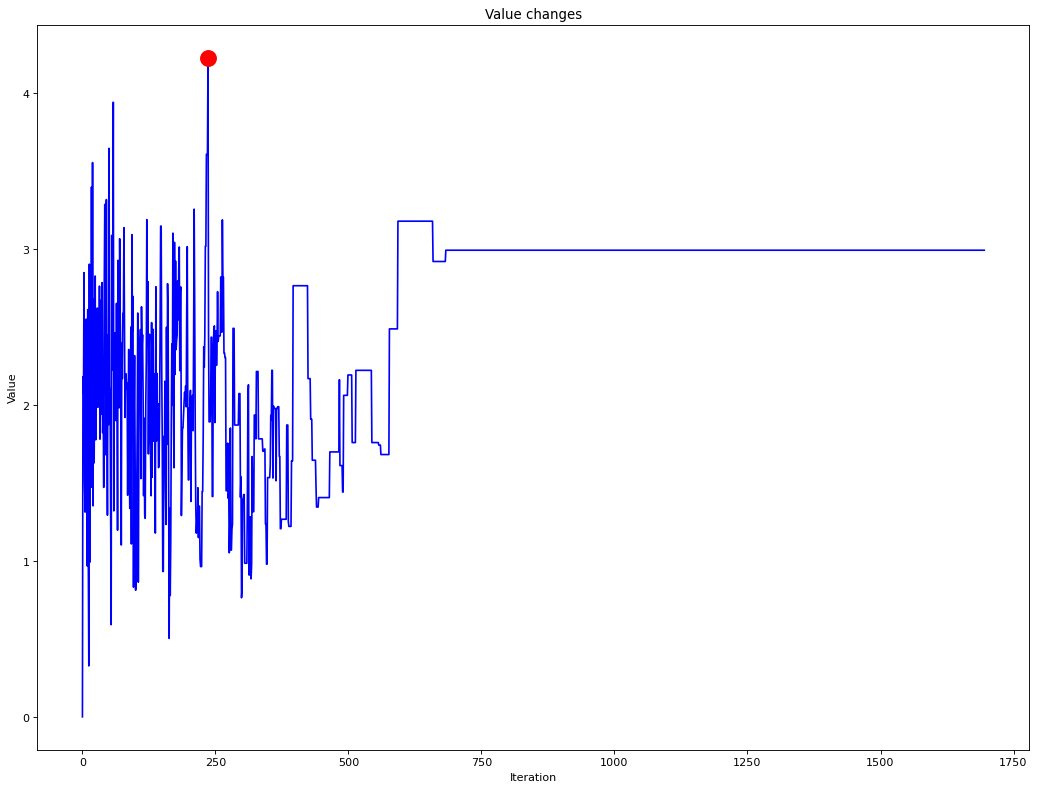

In [18]:
SA.plot_results()

### Best values change plot

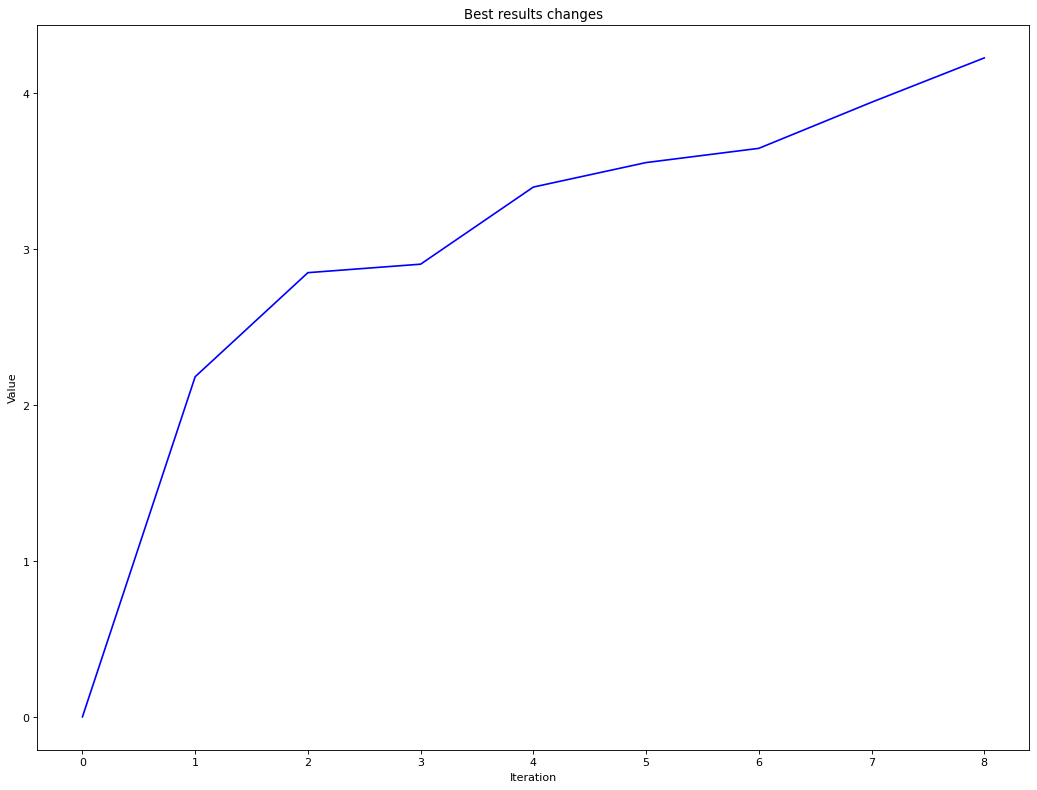

In [19]:
SA.plot_results(plot='best_changes')

## Wnioski

Podana implementacja algorytmu Simulated Annealing z zdanymi parametrami nie znalazła minimum globalnego dla przeszukiwanego zbioru danych, jednakże pokazuje, że algorytm ma potencjał na szukanie minimów globlanych dzięki temu, że potarfi uciekać z minimów lokalnych i lepiej eksplorować cały przeszukiwany obszar. 

Należałoby poszukać jak najlepszych parametrów, które dadzą dobre wyniki. Połączenie z algorytmem genetycznym pozwoli na lepszą eksploatację.

In [20]:
correlation_levels = ["no", "low", "high"]
item_counts = list(range(16,25))
                  
results = np.zeros((len(item_counts), len(correlation_levels)))

for i, level in enumerate(correlation_levels):
    for j, item_count in enumerate(item_counts):
        csv = read_csv(f"Data//{level}_correlation_{item_count}")
        n_items = csv.shape[0]
        values = csv.value.values
        weights = csv.weight.values
        
        SA = SimulatedAnnealing(best_temp, best_cooling, 0.0001, item_count, values, weights, max_weight)
        SA.setInitialValues()
        SA.run()
        results[j,i] = SA.results()
        print(f"Tests finished: {i*len(item_counts)+j}/{len(item_counts)*len(correlation_levels)-1}", end="\r")
        

In [21]:
df_res = DataFrame(data=results, columns=correlation_levels, index=item_counts)
df_res

,no,low,high
16,3.690178,3.916876,4.827003
17,4.271999,4.952518,5.074306
18,6.794058,7.673430,6.563229
19,4.912355,4.634945,4.917624
20,4.409648,4.222085,4.975506
21,5.815627,5.837355,5.092031
22,4.063167,4.011114,4.780197
23,6.056065,6.352341,6.012291
24,4.582338,4.782561,5.297451


<AxesSubplot:title={'center':'Result for correlated data'}, xlabel='Items', ylabel='Value'>

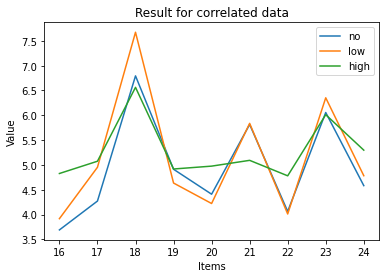

In [23]:
df_res.plot(title="Result for correlated data", xlabel="Items", ylabel="Value")

In [24]:
df_res.to_csv("Results//SA.csv")